[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/qmri_sg_challenge_2024_t1.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:qmri_sg_challenge_2024_t1.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# QMRI Challenge ISMRM 2024 - $T_1$ mapping

In [2]:
# Imports
import shutil
import tempfile
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import zenodo_get
from einops import rearrange
from mpl_toolkits.axes_grid1 import make_axes_locatable  # type: ignore [import-untyped]
from mrpro.algorithms.optimizers import adam
from mrpro.data import IData
from mrpro.operators import MagnitudeOp
from mrpro.operators.functionals import MSE
from mrpro.operators.models import InversionRecovery

### Overview
The dataset consists of images obtained at 10 different inversion times using a turbo spin echo sequence. Each
inversion time is saved in a separate DICOM file. In order to obtain a $T_1$ map, we are going to:
- download the data from Zenodo
- read in the DICOM files (one for each inversion time) and combine them in an IData object
- define a signal model and data loss (mean-squared error) function
- find good starting values for each pixel
- carry out a fit using ADAM from PyTorch

### Get data from Zenodo

In [3]:
data_folder = Path(tempfile.mkdtemp())
dataset = '10868350'
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries
with zipfile.ZipFile(data_folder / Path('T1 IR.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_folder)

Title: Quantitative Study Group: T_1
Keywords: 
Publication date: 2024-03-25
DOI: 10.5281/zenodo.10868350
Total size: 412.6 kB

Link: https://zenodo.org/records/10868350/files/T1 IR.zip   size: 412.6 kB



Checksum is correct. (ccd5f719680c4b5396ec5fb0932f66e1)
All files have been downloaded.


### Create image data (IData) object with different inversion times

In [4]:
ti_dicom_files = data_folder.glob('**/*.dcm')
idata_multi_ti = IData.from_dicom_files(ti_dicom_files)

if idata_multi_ti.header.ti is None:
    raise ValueError('Inversion times need to be defined in the DICOM files.')

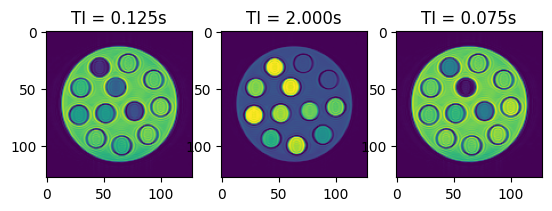

In [5]:
# Let's have a look at some of the images
fig, axes = plt.subplots(1, 3, squeeze=False)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(torch.abs(idata_multi_ti.data[idx, 0, 0, :, :]))
    ax.set_title(f'TI = {idata_multi_ti.header.ti[idx]:.3f}s')

### Signal model and loss function
We use the model $q$

$q(TI) = M_0 (1 - e^{-TI/T_1})$

with the equilibrium magnetization $M_0$, the inversion time $TI$, and $T_1$. We have to keep in mind that the DICOM
images only contain the magnitude of the signal. Therefore, we need $|q(TI)|$:

In [6]:
model = MagnitudeOp() @ InversionRecovery(ti=idata_multi_ti.header.ti)

As a loss function for the optimizer, we calculate the mean-squared error between the image data $x$ and our signal
model $q$.

In [7]:
mse = MSE(idata_multi_ti.data.abs())

Now we can simply combine the two into a functional to solve

$ \min_{M_0, T_1} || |q(M_0, T_1, TI)| - x||_2^2$

In [8]:
functional = mse @ model

### Starting values for the fit
We are trying to minimize a non-linear function $q$. There is no guarantee that we reach the global minimum, but we
can end up in a local minimum.

To increase our chances of reaching the global minimum, we can ensure that our starting
values are already close to the global minimum. We need a good starting point for each pixel.

One option to get a good starting point is to calculate the signal curves for a range of $T_1$ values and then check
for each pixel which of these signal curves fits best. This is similar to what is done for MR Fingerprinting. So we
are going to:
- define a list of realistic $T_1$ values (we call this a dictionary of $T_1$ values)
- calculate the signal curves corresponding to each of these $T_1$ values
- compare the signal curves to the signals of each voxel (we use the maximum of the dot-product as a metric of how
well the signals fit to each other)

In [9]:
# Define 100 T1 values between 0.1 and 3.0 s
t1_dictionary = torch.linspace(0.1, 3.0, 100)

# Calculate the signal corresponding to each of these T1 values. We set M0 to 1, but this is arbitrary because M0 is
# just a scaling factor and we are going to normalize the signal curves.
(signal_dictionary,) = model(torch.ones(1), t1_dictionary)
signal_dictionary = signal_dictionary.to(dtype=torch.complex64)
vector_norm = torch.linalg.vector_norm(signal_dictionary, dim=0)
signal_dictionary /= vector_norm

# Calculate the dot-product and select for each voxel the T1 values that correspond to the maximum of the dot-product
n_y, n_x = idata_multi_ti.data.shape[-2:]
dot_product = torch.mm(rearrange(idata_multi_ti.data, 'other 1 z y x->(z y x) other'), signal_dictionary)
idx_best_match = torch.argmax(torch.abs(dot_product), dim=1)
t1_start = rearrange(t1_dictionary[idx_best_match], '(y x)->1 1 y x', y=n_y, x=n_x)

In [10]:
# The maximum absolute value observed is a good approximation for m0
m0_start = torch.amax(torch.abs(idata_multi_ti.data), 0)

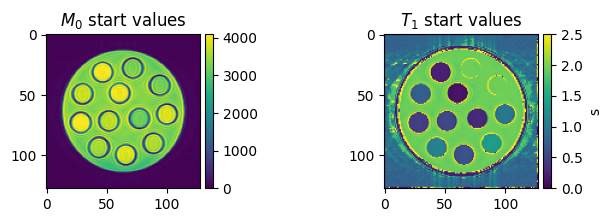

In [11]:
# Visualize the starting values
fig, axes = plt.subplots(1, 2, figsize=(8, 2), squeeze=False)
colorbar_ax = [make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05) for ax in axes[0, :]]
im = axes[0, 0].imshow(m0_start[0, 0, ...])
axes[0, 0].set_title('$M_0$ start values')
fig.colorbar(im, cax=colorbar_ax[0])
im = axes[0, 1].imshow(t1_start[0, 0, ...], vmin=0, vmax=2.5)
axes[0, 1].set_title('$T_1$ start values')
fig.colorbar(im, cax=colorbar_ax[1], label='s')

### Carry out fit

In [12]:
# Hyperparameters for optimizer
max_iter = 2000
lr = 1e-1

# Run optimization
params_result = adam(functional, [m0_start, t1_start], max_iter=max_iter, lr=lr)
m0, t1 = (p.detach() for p in params_result)
m0[torch.isnan(t1)] = 0
t1[torch.isnan(t1)] = 0

### Visualize the final results
To get an impression of how well the fit has worked, we are going to calculate the relative error between

$E_{relative} = \sum_{TI}\frac{|(q(M_0, T_1, TI) - x)|}{|x|}$

on a voxel-by-voxel basis

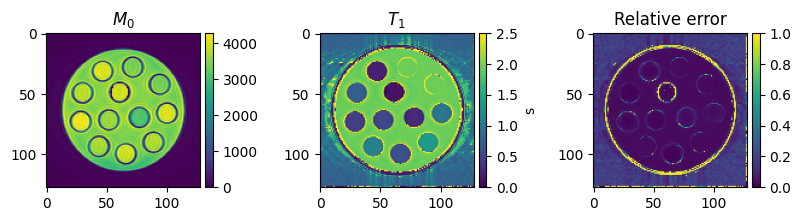

In [13]:
img_mult_te_abs_sum = torch.sum(torch.abs(idata_multi_ti.data), dim=0)
relative_absolute_error = torch.sum(torch.abs(model(m0, t1)[0] - idata_multi_ti.data), dim=0) / (
    img_mult_te_abs_sum + 1e-9
)
fig, axes = plt.subplots(1, 3, figsize=(10, 2), squeeze=False)
colorbar_ax = [make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05) for ax in axes[0, :]]
im = axes[0, 0].imshow(m0[0, 0, ...])
axes[0, 0].set_title('$M_0$')
fig.colorbar(im, cax=colorbar_ax[0])
im = axes[0, 1].imshow(t1[0, 0, ...], vmin=0, vmax=2.5)
axes[0, 1].set_title('$T_1$')
fig.colorbar(im, cax=colorbar_ax[1], label='s')
im = axes[0, 2].imshow(relative_absolute_error[0, 0, ...], vmin=0, vmax=1.0)
axes[0, 2].set_title('Relative error')
fig.colorbar(im, cax=colorbar_ax[2])

In [14]:
# Clean-up by removing temporary directory
shutil.rmtree(data_folder)